# Advanced Lane Tracking
## Introduction
This notebook includes the calibration and testing for an algorithm to detect and track lane lines within videos of road driving. An example from from a video feed is shown below.

![Example Road Image](./test_images/test5.jpg)
    
The pipeline is implemented in the following steps:
* Camera calibration matrix and distortion coefficients are estimated from a set of chessboard images at multiple perspectives. This is performed at initialization, and the calibration/distortion is assumed to hold for all further tests.
* Video feed is processed 'per frame' with:
    * Distortion correction is enable raw images.
    * Color space conversion and computer vision processing, such as thresholding and gradient estimation, are used to generate a thresholded binary image.
    * The binary image is transformed to a "birds-eye view" with a perspective transform.
    * Histogram and window/convolution operations are applied to detect lane pixels and to estimate the lane.
    * Lane curvature and vehicle position are estimated.
    * Lane estimates are re-projected into the original image for visualization.
* The final video displays the lane boundaries and provides the numerical estimation of lane curvature and vehicle position.


In [138]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import pickle

## Camera Calibration
Camera Calibration is performed using a set of supplied images of a calibration target, in this case a chessboard pattern.



Text(0.5,1,'Chessboard Calibration Image')

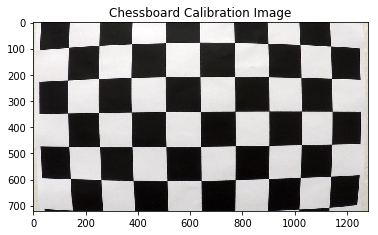

In [6]:
calibration_dir = "./camera_cal/"
test_image = "calibration1.jpg"
calimg = mpimg.imread(calibration_dir + test_image)
plt.imshow(calimg)
plt.title('Chessboard Calibration Image')



In [154]:
def calCamera(cal_dir = "./camera_cal", out_dir = "./cal_output", debug = 0):
    # Estimate the camera calibration matrix from images in the calibration directory.
    # Images should be available with a the name: 
    #    "calibration<n>.jpg",
    # where <n> is a sequential numbering of the images.
    files = os.listdir(cal_dir)
    
    # Generate Object Points
    num_corners = (9,6 )
    pts_grid = np.meshgrid(np.arange(0,num_corners[0],dtype = np.float32),\
                           np.arange(0,num_corners[1],dtype = np.float32))
    gx = pts_grid[0].reshape([1,-1])
    gy = pts_grid[1].reshape([1,-1])
    obj_points0 = np.concatenate([gx,gy,np.zeros_like(gx)]).T
    
    objpoints = list()
    imgpoints = list()
    
    for file in files:
        if file.startswith('calibration'):            
            cal_img = mpimg.imread(calibration_dir + file)
            gray = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, num_corners, None)
            if ret:
                imgpoints.append(corners)
                objpoints.append(obj_points0)
                cal_img = cv2.drawChessboardCorners(cal_img, num_corners, corners, ret)
                mpimg.imsave(out_dir + '/Corners'+file,cal_img)
    
    # Fit Distortion Matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
        gray.shape[::-1], None, None)
    print(ret)
    # Test Un-Distort (Save images to out_dir)
    if debug:
        for file in files:
            if file.startswith('calibration'):
                dist_img = mpimg.imread(calibration_dir + file)
                undist = cv2.undistort(dist_img, mtx, dist, None, mtx)
                mpimg.imsave(out_dir + '/Undist' + file, undist)
            
    # Return Values
    return ret, mtx, dist
ret, mtx, dist = calCamera(debug = 1)

1.1868973603423723


In [155]:
# Pickle Calibration
if ret:
    pickle.dump([mtx, dist],open("camera_calibration.p", 'wb'))

# Test Pickle
mtx_back = mtx
dist_back = dist
mtx = []
dist = []
[mtx,dist] = pickle.load(open("camera_calibration.p", 'rb'))
print(mtx)
print(dist)

[[1.15396093e+03 0.00000000e+00 6.69705357e+02]
 [0.00000000e+00 1.14802496e+03 3.85656234e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.41017956e-01 -5.30721173e-02 -1.15810355e-03 -1.28318856e-04
   2.67125290e-02]]


# Summary
The following images show the Camera Calibration process:
* Image 1 shows the Uncalibrated image.
* Image 2 shows the identification of the chessboard pattern, using openCV findChessboardCorners
* Image 3 shows the distortion corrected image, using the calibration calcualted over all available calibration images.

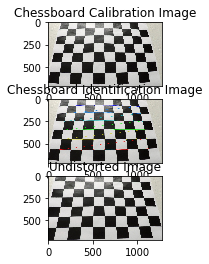

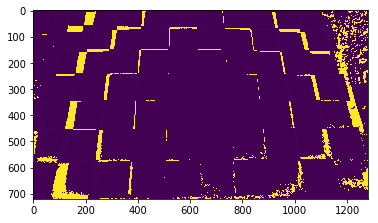

In [177]:
demo_image = "./camera_cal/calibration3.jpg"
demo_image_chess = "./cal_output/Cornerscalibration3.jpg"
demo_image_undist = "./cal_output/Undistcalibration3.jpg"

demo_img = mpimg.imread(demo_image)
demo_img_chess = mpimg.imread(demo_image_chess)
demo_img_undist = mpimg.imread(demo_image_undist)

plt.subplot(3,1,1)
plt.imshow(demo_img)
plt.title('Chessboard Calibration Image')

plt.subplot(3,1,2)
plt.imshow(demo_img_chess)
plt.title('Chessboard Identification Image')

plt.subplot(3,1,3)
plt.imshow(demo_img_undist)
plt.title('Undistorted Image')

plt.show()

# Test
demo_img_undist = cv2.cvtColor(demo_img_undist, cv2.COLOR_RGB2GRAY)
demo_img_undist_bin = np.zeros_like(demo_img_undist)
demo_img_undist_bin[demo_img_undist > 200] = 1
demo_img = cv2.cvtColor(demo_img, cv2.COLOR_RGB2GRAY)
demo_img_bin = np.zeros_like(demo_img)
demo_img_bin[demo_img > 200] = 1
plt.imshow(demo_img_bin-demo_img_undist_bin)
